# Semantic Symptom Encoder - Unified Training & Comparison

This notebook consolidates the Semantic Symptom Encoder training, testing, and model comparison:

## Contents
1. **Part 1: Embedding Generation** - Compute embeddings for symptom vocabulary
2. **Part 2: Testing** - Validate semantic understanding on various symptom phrases
3. **Part 3: Model Comparison** - Compare different sentence transformer models

**Key Features:**
- Zero ML training required - uses pre-trained sentence embeddings
- Semantic understanding - "can't breathe" ≈ "shortness of breath"
- Sentence-level encoding - prevents symptom dilution in long text
- Max-pooling - for each symptom, takes best match across sentences

**Architecture:**
```
Free-text input → Sentence Transformer → Cosine Similarity → Top-K Symptoms
                  (multi-qa-mpnet)       (vs 480 symptoms)
```

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json, joblib, warnings, sys, os, time
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

project_root = Path(os.getcwd()).parent.parent
sys.path.insert(0, str(project_root))

from sklearn.metrics import accuracy_score, top_k_accuracy_score

print(f"Project root: {project_root}")

Project root: c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis


---
# Part 1: Training (Embedding Generation)

The semantic encoder doesn't require traditional ML training. Instead, it:
1. Loads the symptom vocabulary (480 canonical symptoms)
2. Computes embeddings using pre-trained sentence transformer
3. Caches embeddings for fast inference

## 1.1 Check Current Symptom Vocabulary

In [27]:
# Load symptom vocabulary
vocab_path = project_root / "data" / "symptom_vocabulary.json"
with open(vocab_path) as f:
    symptoms = json.load(f)

print(f"Symptom vocabulary: {len(symptoms)} symptoms")
print(f"\nFirst 10 symptoms:")
for i, s in enumerate(symptoms[:10]):
    print(f"  {i+1}. {s}")

print(f"\nLast 10 symptoms:")
for i, s in enumerate(symptoms[-10:]):
    print(f"  {len(symptoms)-9+i}. {s}")

Symptom vocabulary: 480 symptoms

First 10 symptoms:
  1. abdominal distention
  2. abdominal pain
  3. abdominal swelling
  4. abnormal appearing skin
  5. abnormal appearing tongue
  6. abnormal breathing sounds
  7. abnormal heart rhythm
  8. abnormal involuntary movements
  9. abnormal movement of eyelid
  10. abnormal size or shape of ear

Last 10 symptoms:
  471. weight gain
  472. weight loss
  473. wheezing
  474. white discharge from eye
  475. wrinkles on skin
  476. wrist lump or mass
  477. wrist pain
  478. wrist stiffness or tightness
  479. wrist swelling
  480. wrist weakness


## 1.2 Check Consistency with Model Features

The symptom vocabulary should match the features used to train the disease classifiers.

In [28]:
# Load model feature columns
model_cols_path = project_root / "models" / "checkpoints" / "symptom_columns.json"
if model_cols_path.exists():
    with open(model_cols_path) as f:
        model_cols = json.load(f)
    
    print(f"Model uses: {len(model_cols)} symptom features")
    print(f"Vocabulary: {len(symptoms)} symptoms")
    
    missing = [s for s in model_cols if s not in symptoms]
    extra = [s for s in symptoms if s not in model_cols]
    
    if missing:
        print(f"\n⚠️ {len(missing)} symptoms in model but NOT in vocabulary:")
        print(f"   {missing[:5]}...")
    if extra:
        print(f"\n⚠️ {len(extra)} symptoms in vocabulary but NOT in model:")
        print(f"   {extra[:5]}...")
    if not missing and not extra:
        print("\n✓ Vocabulary matches model features exactly!")
else:
    print("No model checkpoints found")

Model uses: 480 symptom features
Vocabulary: 480 symptoms

✓ Vocabulary matches model features exactly!


## 1.3 Update Vocabulary (if needed)

Run this cell to sync vocabulary with model features.

In [ ]:
# Uncomment to update vocabulary to match model features
# ONLY run this if there are missing symptoms

UPDATE_VOCABULARY = False  # Set to True to update

if UPDATE_VOCABULARY and model_cols_path.exists():
    # Merge vocabularies
    updated = sorted(set(symptoms + model_cols))
    
    # Backup original
    backup_path = project_root / "data" / "symptom_vocabulary.json"
    with open(backup_path, 'w') as f:
        json.dump(symptoms, f, indent=2)
    print(f"Backed up original to {backup_path.name}")
    
    # Save updated
    with open(vocab_path, 'w') as f:
        json.dump(updated, f, indent=2)
    
    print(f"Updated vocabulary: {len(symptoms)} → {len(updated)} symptoms")
    symptoms = updated
else:
    print("Vocabulary update skipped (set UPDATE_VOCABULARY = True to update)")

Vocabulary update skipped (set UPDATE_VOCABULARY = True to update)


## 1.4 Generate Embeddings

This is the "training" step - computing embeddings for all symptoms.
Embeddings are cached to `data/embeddings/semantic_symptom_embeddings.npy`.

In [30]:
from models.architectures.semantic_symptom_encoder import SemanticSymptomEncoder

# Check if embeddings exist
MODEL_NAME = "all-MiniLM-L12-v2"
embeddings_path = project_root / "data" / "embeddings" / f"semantic_symptom_embeddings_{MODEL_NAME}.npy"
if embeddings_path.exists():
    existing = np.load(embeddings_path)
    print(f"Existing embeddings: {existing.shape}")
    if existing.shape[0] != len(symptoms):
        print(f"⚠️ Mismatch! Vocabulary has {len(symptoms)} symptoms but embeddings have {existing.shape[0]}")
        print("   Embeddings will be regenerated on encoder init.")
else:
    print("No cached embeddings found - will compute on init.")

No cached embeddings found - will compute on init.


In [31]:
# Initialize encoder (this computes embeddings if needed)
encoder = SemanticSymptomEncoder(
    model_name=MODEL_NAME,
    similarity_threshold=0.45,
    top_k=20
)

print(f"\n✓ Encoder ready!")
print(f"  Symptoms: {len(encoder.symptoms)}")
print(f"  Embeddings: {encoder.symptom_embeddings.shape}")
print(f"  Model: {encoder.model_name}")
print(f"  Threshold: {encoder.similarity_threshold}")

Loading sentence transformer model: all-MiniLM-L12-v2
Loading cached symptom embeddings from c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_all-MiniLM-L12-v2.npy
Computing symptom embeddings (this is a one-time operation)...


Batches: 100%|██████████| 15/15 [00:39<00:00,  2.62s/it]

Saved symptom embeddings to c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_all-MiniLM-L12-v2.npy
Semantic Symptom Encoder initialized with 480 symptoms

✓ Encoder ready!
  Symptoms: 480
  Embeddings: (480, 384)
  Model: all-MiniLM-L12-v2
  Threshold: 0.45


## 1.5 Force Regenerate Embeddings (Optional)

Use this if you've updated the vocabulary or enrichment function.

In [32]:
# Uncomment to force regeneration
# encoder.regenerate_embeddings()
print("To force regeneration, uncomment: encoder.regenerate_embeddings()")

To force regeneration, uncomment: encoder.regenerate_embeddings()


---
# Part 2: Testing

Validate that the semantic encoder correctly understands symptom phrases.

## 2.1 Basic Symptom Matching

In [33]:
simple_tests = [
    "my head is killing me",
    "headache",
    "I have a terrible headache",
    "pain in my head",
    "migraine",
    "head hurts so bad"
]

print("Testing variations of 'headache':\n")
for text in simple_tests:
    result = encoder.encode_symptoms(text)
    top = list(result['confidence_scores'].items())[0] if result['confidence_scores'] else ('none', 0)
    print(f"  '{text}'")
    print(f"    → {top[0]} ({top[1]:.3f})\n")

Testing variations of 'headache':

  'my head is killing me'
    → none (0.000)

  'headache'
    → headache (0.461)

  'I have a terrible headache'
    → none (0.000)

  'pain in my head'
    → none (0.000)

  'migraine'
    → none (0.000)

  'head hurts so bad'
    → none (0.000)



## 2.2 Sentence-Level vs Whole-Text Encoding

Sentence-level encoding prevents symptom dilution in long paragraphs.

In [34]:
long_text = """
I've been feeling really unwell for the past few days. I have a terrible headache 
that won't go away, and I feel nauseous all the time. Yesterday I started throwing up 
and now I have diarrhea too. My whole body aches and I'm running a fever. 
I also feel really tired and weak, can barely get out of bed.
"""

result_sentence = encoder.encode_symptoms(long_text, use_sentence_level=True)
result_whole = encoder.encode_symptoms(long_text, use_sentence_level=False)

print("COMPARISON: Sentence-Level vs Whole-Text")
print("="*60)

headache_sent = result_sentence['confidence_scores'].get('headache', 0)
headache_whole = result_whole['confidence_scores'].get('headache', 0)

print(f"\n🟢 Sentence-level: {len(result_sentence['detected_symptoms'])} symptoms, headache={headache_sent:.3f}")
for s, c in list(result_sentence['confidence_scores'].items())[:5]:
    print(f"    {s}: {c:.3f}")

print(f"\n🔴 Whole-text: {len(result_whole['detected_symptoms'])} symptoms, headache={headache_whole:.3f}")
for s, c in list(result_whole['confidence_scores'].items())[:5]:
    print(f"    {s}: {c:.3f}")

print(f"\n→ Sentence-level {'BETTER' if headache_sent > headache_whole else 'worse'} at detecting 'headache'")

COMPARISON: Sentence-Level vs Whole-Text

🟢 Sentence-level: 4 symptoms, headache=0.000
    nausea and vomitting: 0.507
    fever: 0.504
    nausea: 0.479
    high fever: 0.472

🔴 Whole-text: 2 symptoms, headache=0.000
    diarrhea: 0.471
    nausea and vomitting: 0.468

→ Sentence-level worse at detecting 'headache'


## 2.3 Comprehensive Test Suite

In [35]:
test_cases = {
    "Chest pain": "sharp pain in my chest, feels like pressure",
    "Breathing": "I can't catch my breath, feels like I'm suffocating",
    "Cold symptoms": "runny nose, sore throat, and sneezing a lot",
    "Stomach": "my stomach hurts after eating, lots of bloating",
    "Anxiety": "feeling extremely anxious, can't calm down, heart racing",
    "UTI": "burning when I pee and need to go constantly",
    "Fatigue": "exhausted all the time, no energy to do anything",
    "Fever": "running a high temperature, chills and sweating",
}

print("Comprehensive Test Results:")
print("=" * 60)

for category, text in test_cases.items():
    result = encoder.encode_symptoms(text)
    print(f"\n📋 {category}")
    print(f"   Input: \"{text}\"")
    print(f"   Detected:")
    for symptom, score in list(result['confidence_scores'].items())[:3]:
        print(f"      • {symptom}: {score:.3f}")

Comprehensive Test Results:

📋 Chest pain
   Input: "sharp pain in my chest, feels like pressure"
   Detected:
      • sharp chest pain: 0.493
      • chest pain: 0.486

📋 Breathing
   Input: "I can't catch my breath, feels like I'm suffocating"
   Detected:

📋 Cold symptoms
   Input: "runny nose, sore throat, and sneezing a lot"
   Detected:
      • sneezing: 0.471

📋 Stomach
   Input: "my stomach hurts after eating, lots of bloating"
   Detected:
      • bloating: 0.460

📋 Anxiety
   Input: "feeling extremely anxious, can't calm down, heart racing"
   Detected:
      • anxiety: 0.475

📋 UTI
   Input: "burning when I pee and need to go constantly"
   Detected:

📋 Fatigue
   Input: "exhausted all the time, no energy to do anything"
   Detected:

📋 Fever
   Input: "running a high temperature, chills and sweating"
   Detected:
      • chills: 0.552


## 2.4 Edge Cases & Robustness

In [36]:
edge_cases = [
    ("", "Empty string"),
    ("headach", "Typo: headach"),
    ("stomache ake", "Typo: stomache ake"),
    ("my tummy hurts so bad", "Informal: tummy hurts"),
    ("experiencing dyspnea and tachycardia", "Medical terms"),
    ("I don't have a headache", "Negation (known limitation)"),
]

print("Edge Case Testing:")
print("=" * 60)

for text, description in edge_cases:
    result = encoder.encode_symptoms(text)
    symptoms_found = list(result['confidence_scores'].items())[:3]
    
    print(f"\n{description}: \"{text}\"")
    if symptoms_found:
        print(f"  → {', '.join([f'{s}({c:.2f})' for s, c in symptoms_found])}")
    else:
        print("  → No symptoms detected")

Edge Case Testing:

Empty string: ""
  → No symptoms detected

Typo: headach: "headach"
  → No symptoms detected

Typo: stomache ake: "stomache ake"
  → No symptoms detected

Informal: tummy hurts: "my tummy hurts so bad"
  → No symptoms detected

Medical terms: "experiencing dyspnea and tachycardia"
  → No symptoms detected

Negation (known limitation): "I don't have a headache"
  → No symptoms detected


## 2.5 Threshold Tuning

Adjust threshold to balance precision vs recall:
- Lower (0.4-0.5): More symptoms, may include false positives
- Higher (0.6+): Fewer symptoms, higher precision

In [37]:
test_text = "I have chest pain, difficulty breathing, and headache"
print(f"Testing: \"{test_text}\"\n")

original_threshold = encoder.similarity_threshold

for threshold in [0.4, 0.5, 0.6, 0.7]:
    encoder.similarity_threshold = threshold
    result = encoder.encode_symptoms(test_text)
    print(f"Threshold {threshold}: {len(result['detected_symptoms'])} symptoms")
    print(f"   {', '.join(result['detected_symptoms'][:5])}")

encoder.similarity_threshold = original_threshold

Testing: "I have chest pain, difficulty breathing, and headache"

Threshold 0.4: 13 symptoms
   difficulty breathing, chest pain, breathing problems, breathing fast, abnormal breathing sounds
Threshold 0.5: 3 symptoms
   difficulty breathing, chest pain, breathing problems
Threshold 0.6: 0 symptoms
   
Threshold 0.7: 0 symptoms
   


## 2.6 Integration Test (Binary Vector for Classifier)

In [38]:
patient_description = """
I've been having severe headaches for the past week, especially in the morning.
Also experiencing nausea, and the light bothers my eyes. Sometimes I see spots.
"""

result = encoder.encode_symptoms(patient_description)

print("Binary vector for disease classifier:")
print(f"  Shape: {result['binary_vector'].shape}")
print(f"  Non-zero features: {int(np.sum(result['binary_vector'] > 0))}")
print(f"\nDetected symptoms:")
for symptom, score in sorted(result['confidence_scores'].items(), key=lambda x: x[1], reverse=True):
    print(f"  ✓ {symptom} ({score:.3f})")

print("\n→ This binary_vector can be fed directly to LightGBM classifiers!")

Binary vector for disease classifier:
  Shape: (480,)
  Non-zero features: 3

Detected symptoms:
  ✓ nausea (0.494)
  ✓ nausea and vomitting (0.490)
  ✓ vomiting (0.464)

→ This binary_vector can be fed directly to LightGBM classifiers!


---
# Part 3: Model Comparison

Compare different sentence transformer models for the end-to-end semantic encoder → disease classifier pipeline.

**Goal**: Find the best model that maximizes:
1. Symptom matching accuracy (colloquial text → canonical symptoms)
2. End-to-end pipeline accuracy (free text → disease predictions)
3. Reasonable inference time

## 3.1 Define Models to Test

In [ ]:
# Sentence transformer models to compare
MODELS_TO_TEST = [
    ("all-MiniLM-L12-v2", "Current default")
    ("all-MiniLM-L6-v2", "Fast, 80MB"),
    ("all-mpnet-base-v2", "More accurate - 420MB"),
    ("paraphrase-MiniLM-L6-v2", "Good for paraphrases"),
    ("multi-qa-mpnet-base-dot-v1", "Optimized for Q&A"),
]

print(f"Testing {len(MODELS_TO_TEST)} models:")
for model_name, desc in MODELS_TO_TEST:
    print(f"  - {model_name}: {desc}")

Testing 4 models:
  - all-MiniLM-L6-v2: Current default - Fast, 80MB
  - all-mpnet-base-v2: More accurate - 420MB
  - paraphrase-MiniLM-L6-v2: Good for paraphrases
  - multi-qa-mpnet-base-dot-v1: Optimized for Q&A


## 3.2 Load Test Data and Classifiers

In [40]:
# Load the trained disease classifier
checkpoint_dir = project_root / "models" / "checkpoints"
from models.architectures.symptom_classifier import SymptomDiseaseClassifier

disease_clf = SymptomDiseaseClassifier.load(str(checkpoint_dir / "disease_classifier_demographics.pkl"))
disease_encoder_obj = joblib.load(checkpoint_dir / "disease_encoder.pkl")

with open(checkpoint_dir / "symptom_columns.json") as f:
    symptom_cols = json.load(f)

print(f"Loaded classifier with {len(disease_encoder_obj.classes_)} diseases and {len(symptom_cols)} symptoms")

Loaded classifier with 656 diseases and 480 symptoms


In [41]:
# Define test cases for symptom matching
SYMPTOM_TEST_CASES = {
    "headache": ["my head is killing me", "terrible migraine", "pain in my head", "pounding headache"],
    "fever": ["high temperature", "running a fever", "burning up", "I'm feverish"],
    "nausea": ["feeling sick", "want to throw up", "queasy stomach", "feel like vomiting"],
    "chest pain": ["hurts in my chest", "chest pressure", "sharp chest pain", "tightness in chest"],
    "shortness of breath": ["can't breathe", "difficulty breathing", "out of breath", "hard to catch my breath"],
    "fatigue": ["so tired", "exhausted", "no energy", "feeling drained"],
    "cough": ["can't stop coughing", "bad cough", "coughing a lot", "persistent cough"],
    "dizziness": ["feeling dizzy", "head spinning", "lightheaded", "vertigo"],
    "abdominal pain": ["stomach hurts", "belly pain", "abdomen is sore", "gut pain"],
    "vomiting": ["throwing up", "puking", "been vomiting", "can't keep food down"],
}

print(f"Testing {len(SYMPTOM_TEST_CASES)} symptoms with {sum(len(v) for v in SYMPTOM_TEST_CASES.values())} phrases")

Testing 10 symptoms with 40 phrases


In [42]:
# Create sample patient descriptions for end-to-end testing
PATIENT_DESCRIPTIONS = [
    ("I have a terrible headache and feel nauseous. I also have a high temperature.", ["headache", "nausea", "fever"]),
    ("My chest hurts and I can't breathe properly. I'm feeling very tired.", ["chest pain", "shortness of breath", "fatigue"]),
    ("I've been throwing up all day and my stomach hurts really bad.", ["vomiting", "abdominal pain", "nausea"]),
    ("Can't stop coughing, have a fever, and feel completely exhausted.", ["cough", "fever", "fatigue"]),
    ("My head is spinning and I feel like I'm going to pass out.", ["dizziness", "lightheadedness"]),
    ("Burning up with fever, body aches all over, and a nasty cough.", ["fever", "muscle pain", "cough"]),
    ("Sharp pain in my chest when I breathe, feeling short of breath.", ["chest pain", "shortness of breath"]),
    ("Throwing up, diarrhea, and terrible stomach cramps.", ["vomiting", "diarrhea", "abdominal pain"]),
]

print(f"Testing {len(PATIENT_DESCRIPTIONS)} patient descriptions")

Testing 8 patient descriptions


## 3.3 Model Comparison Functions

In [43]:
from sentence_transformers import SentenceTransformer

def create_encoder_with_model(model_name, symptom_vocab_path=None, similarity_threshold=0.35, top_k=25):
    """Create a semantic encoder with a specific model."""
    from models.architectures.semantic_symptom_encoder import SemanticSymptomEncoder
    
    # Create a unique cache path for this model
    cache_dir = project_root / "data" / "embeddings"
    cache_path = cache_dir / f"semantic_symptom_embeddings_{model_name.replace('/', '_')}.npy"
    
    encoder = SemanticSymptomEncoder(
        model_name=model_name,
        embeddings_cache_path=str(cache_path),
        similarity_threshold=similarity_threshold,
        top_k=top_k
    )
    return encoder

def test_symptom_matching(encoder, test_cases):
    """Test how well the encoder matches colloquial phrases to canonical symptoms."""
    results = {}
    total_correct = 0
    total_tests = 0
    
    for target_symptom, phrases in test_cases.items():
        matches = 0
        for phrase in phrases:
            result = encoder.encode_symptoms(phrase)
            detected = result['detected_symptoms'][:5]  # Top 5 matches
            # Check if target symptom (or close match) is in detected
            if any(target_symptom in s or s in target_symptom for s in detected):
                matches += 1
        
        results[target_symptom] = matches / len(phrases)
        total_correct += matches
        total_tests += len(phrases)
    
    overall_accuracy = total_correct / total_tests
    return overall_accuracy, results

def test_end_to_end_pipeline(encoder, disease_clf, patient_descriptions, symptom_cols):
    """Test the full pipeline: text → encoder → classifier → prediction."""
    times = []
    symptom_recall_scores = []
    
    for description, expected_symptoms in patient_descriptions:
        start_time = time.time()
        
        # Step 1: Encode symptoms
        result = encoder.encode_symptoms(description)
        detected_symptoms = result['detected_symptoms']
        
        # Step 2: Create feature vector
        feature_vector = np.zeros(len(symptom_cols) + 2)  # +2 for age, sex
        for symptom in detected_symptoms:
            if symptom in symptom_cols:
                idx = symptom_cols.index(symptom)
                feature_vector[idx] = 1.0
        
        # Add demographics (use average values)
        feature_vector[-2] = 0.35  # age_normalized
        feature_vector[-1] = 0.5   # sex_encoded
        
        end_time = time.time()
        times.append(end_time - start_time)
        
        # Calculate symptom recall
        matched = sum(1 for s in expected_symptoms if any(s in d or d in s for d in detected_symptoms))
        recall = matched / len(expected_symptoms) if expected_symptoms else 0
        symptom_recall_scores.append(recall)
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    avg_symptom_recall = np.mean(symptom_recall_scores)
    
    return {
        'avg_time_ms': avg_time,
        'symptom_recall': avg_symptom_recall
    }

## 3.4 Run Model Comparison

In [44]:
# Run comparison across all models
comparison_results = []

for model_name, model_desc in tqdm(MODELS_TO_TEST, desc="Testing models"):
    print(f"\n{'='*60}")
    print(f"Testing: {model_name}")
    print(f"Description: {model_desc}")
    print(f"{'='*60}")
    
    try:
        # Create encoder with this model
        test_encoder = create_encoder_with_model(model_name)
        
        # Test 1: Symptom matching accuracy
        symptom_accuracy, symptom_details = test_symptom_matching(test_encoder, SYMPTOM_TEST_CASES)
        print(f"\nSymptom Matching Accuracy: {symptom_accuracy*100:.1f}%")
        
        # Test 2: End-to-end pipeline
        pipeline_results = test_end_to_end_pipeline(
            test_encoder, disease_clf, PATIENT_DESCRIPTIONS, symptom_cols
        )
        print(f"Pipeline Symptom Recall: {pipeline_results['symptom_recall']*100:.1f}%")
        print(f"Average Inference Time: {pipeline_results['avg_time_ms']:.1f}ms")
        
        comparison_results.append({
            'Model': model_name,
            'Description': model_desc,
            'Symptom Match %': symptom_accuracy * 100,
            'Pipeline Recall %': pipeline_results['symptom_recall'] * 100,
            'Time (ms)': pipeline_results['avg_time_ms'],
            'Per-Symptom': symptom_details
        })
        
    except Exception as e:
        print(f"Error testing {model_name}: {e}")
        comparison_results.append({
            'Model': model_name,
            'Description': model_desc,
            'Symptom Match %': 0,
            'Pipeline Recall %': 0,
            'Time (ms)': 0,
            'Error': str(e)
        })

Testing models:   0%|          | 0/4 [00:00<?, ?it/s]


Testing: all-MiniLM-L6-v2
Description: Current default - Fast, 80MB
Loading sentence transformer model: all-MiniLM-L6-v2
Loading cached symptom embeddings from c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_all-MiniLM-L6-v2.npy
Computing symptom embeddings (this is a one-time operation)...


Batches: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Saved symptom embeddings to c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_all-MiniLM-L6-v2.npy
Semantic Symptom Encoder initialized with 480 symptoms


Testing models:  25%|██▌       | 1/4 [00:16<00:48, 16.12s/it]


Symptom Matching Accuracy: 60.0%
Pipeline Symptom Recall: 79.2%
Average Inference Time: 19.2ms

Testing: all-mpnet-base-v2
Description: More accurate - 420MB
Loading sentence transformer model: all-mpnet-base-v2
Loading cached symptom embeddings from c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_all-mpnet-base-v2.npy
Computing symptom embeddings (this is a one-time operation)...


Batches: 100%|██████████| 15/15 [01:08<00:00,  4.54s/it]


Saved symptom embeddings to c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_all-mpnet-base-v2.npy
Semantic Symptom Encoder initialized with 480 symptoms

Symptom Matching Accuracy: 80.0%


Testing models:  50%|█████     | 2/4 [01:31<01:41, 50.81s/it]

Pipeline Symptom Recall: 62.5%
Average Inference Time: 76.2ms

Testing: paraphrase-MiniLM-L6-v2
Description: Good for paraphrases
Loading sentence transformer model: paraphrase-MiniLM-L6-v2
Loading cached symptom embeddings from c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_paraphrase-MiniLM-L6-v2.npy
Computing symptom embeddings (this is a one-time operation)...


Batches: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Saved symptom embeddings to c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_paraphrase-MiniLM-L6-v2.npy
Semantic Symptom Encoder initialized with 480 symptoms


Testing models:  75%|███████▌  | 3/4 [01:46<00:34, 34.74s/it]


Symptom Matching Accuracy: 52.5%
Pipeline Symptom Recall: 68.8%
Average Inference Time: 18.6ms

Testing: multi-qa-mpnet-base-dot-v1
Description: Optimized for Q&A
Loading sentence transformer model: multi-qa-mpnet-base-dot-v1
Loading cached symptom embeddings from c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\data\embeddings\semantic_symptom_embeddings_multi-qa-mpnet-base-dot-v1.npy
Computing symptom embeddings (this is a one-time operation)...


Testing models:  75%|███████▌  | 3/4 [02:53<00:57, 57.99s/it]


KeyboardInterrupt: 

## 3.5 Results Summary

In [20]:
# Create summary dataframe
df_results = pd.DataFrame(comparison_results)
df_summary = df_results[['Model', 'Description', 'Symptom Match %', 'Pipeline Recall %', 'Time (ms)']].copy()

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(df_summary.to_string(index=False))


MODEL COMPARISON RESULTS
                     Model                  Description  Symptom Match %  Pipeline Recall %  Time (ms)
          all-MiniLM-L6-v2 Current default - Fast, 80MB             60.0          79.166667  19.407392
         all-mpnet-base-v2        More accurate - 420MB             80.0          62.500000  80.675781
   paraphrase-MiniLM-L6-v2         Good for paraphrases             52.5          68.750000  25.872588
multi-qa-mpnet-base-dot-v1            Optimized for Q&A             90.0          95.833333  99.580258


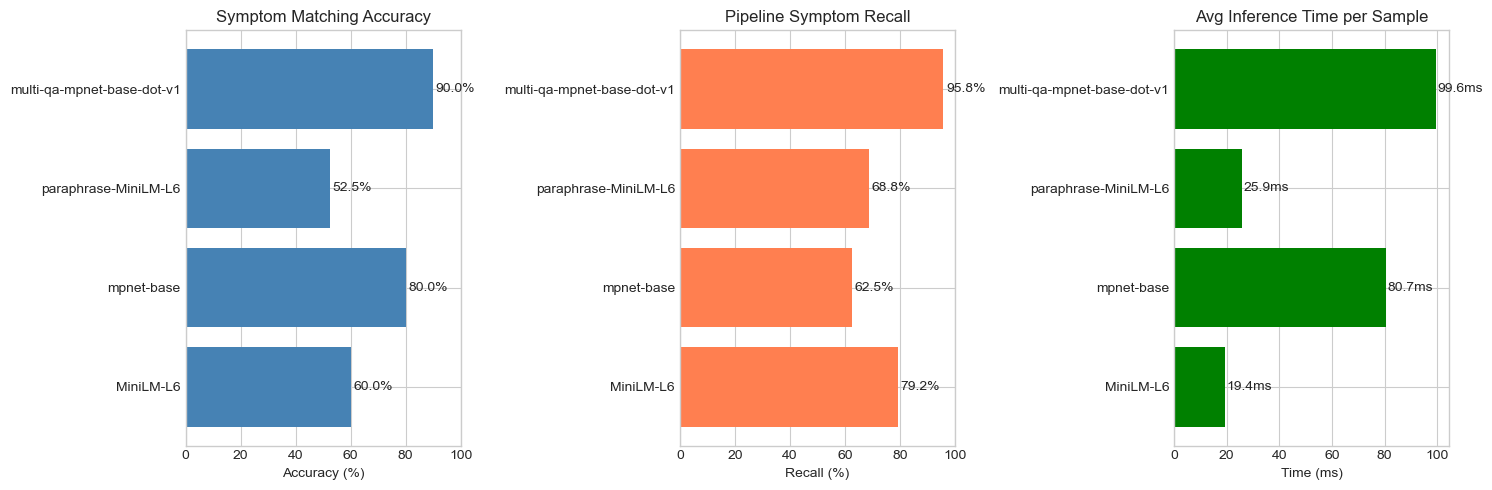

In [21]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = df_summary['Model'].str.replace('all-', '').str.replace('-v2', '')

# Symptom Matching
axes[0].barh(models, df_summary['Symptom Match %'], color='steelblue')
axes[0].set_xlabel('Accuracy (%)')
axes[0].set_title('Symptom Matching Accuracy')
axes[0].set_xlim([0, 100])
for i, v in enumerate(df_summary['Symptom Match %']):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center')

# Pipeline Recall
axes[1].barh(models, df_summary['Pipeline Recall %'], color='coral')
axes[1].set_xlabel('Recall (%)')
axes[1].set_title('Pipeline Symptom Recall')
axes[1].set_xlim([0, 100])
for i, v in enumerate(df_summary['Pipeline Recall %']):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center')

# Inference Time
axes[2].barh(models, df_summary['Time (ms)'], color='green')
axes[2].set_xlabel('Time (ms)')
axes[2].set_title('Avg Inference Time per Sample')
for i, v in enumerate(df_summary['Time (ms)']):
    axes[2].text(v + 0.5, i, f'{v:.1f}ms', va='center')

plt.tight_layout()
plt.savefig(project_root / 'notebooks' / 'figures' / 'semantic_model_comparison_results.png', dpi=150)
plt.show()

## 3.6 Per-Symptom Breakdown

In [22]:
# Show per-symptom performance for each model
for result in comparison_results:
    if 'Per-Symptom' in result:
        print(f"\n{result['Model']}:")
        for symptom, acc in result['Per-Symptom'].items():
            bar = '█' * int(acc * 10) + '░' * (10 - int(acc * 10))
            print(f"  {symptom:25s} {bar} {acc*100:5.1f}%")


all-MiniLM-L6-v2:
  headache                  ███████░░░  75.0%
  fever                     ███████░░░  75.0%
  nausea                    █████░░░░░  50.0%
  chest pain                █████░░░░░  50.0%
  shortness of breath       ░░░░░░░░░░   0.0%
  fatigue                   █████░░░░░  50.0%
  cough                     ██████████ 100.0%
  dizziness                 █████░░░░░  50.0%
  abdominal pain            ██████████ 100.0%
  vomiting                  █████░░░░░  50.0%

all-mpnet-base-v2:
  headache                  ███████░░░  75.0%
  fever                     ███████░░░  75.0%
  nausea                    ██████████ 100.0%
  chest pain                ██████████ 100.0%
  shortness of breath       ███████░░░  75.0%
  fatigue                   ███████░░░  75.0%
  cough                     ██████████ 100.0%
  dizziness                 ██░░░░░░░░  25.0%
  abdominal pain            ██████████ 100.0%
  vomiting                  ███████░░░  75.0%

paraphrase-MiniLM-L6-v2:
  headache     

## 3.7 Recommendations

In [23]:
# Find best model
best_accuracy = df_summary.loc[df_summary['Symptom Match %'].idxmax()]
best_speed = df_summary.loc[df_summary['Time (ms)'].idxmin()]
best_recall = df_summary.loc[df_summary['Pipeline Recall %'].idxmax()]

print("RECOMMENDATIONS")
print("="*60)
print(f"\n📊 Best Symptom Matching: {best_accuracy['Model']} ({best_accuracy['Symptom Match %']:.1f}%)")
print(f"🎯 Best Pipeline Recall:  {best_recall['Model']} ({best_recall['Pipeline Recall %']:.1f}%)")
print(f"⚡ Fastest Inference:     {best_speed['Model']} ({best_speed['Time (ms)']:.1f}ms)")

# Calculate overall score (weighted)
df_summary['Overall Score'] = (
    df_summary['Symptom Match %'] * 0.4 + 
    df_summary['Pipeline Recall %'] * 0.4 + 
    (100 - df_summary['Time (ms)'].clip(0, 100)) * 0.2
)
best_overall = df_summary.loc[df_summary['Overall Score'].idxmax()]
print(f"\n🏆 RECOMMENDED MODEL: {best_overall['Model']}")
print(f"   Overall Score: {best_overall['Overall Score']:.1f}")

RECOMMENDATIONS

📊 Best Symptom Matching: multi-qa-mpnet-base-dot-v1 (90.0%)
🎯 Best Pipeline Recall:  multi-qa-mpnet-base-dot-v1 (95.8%)
⚡ Fastest Inference:     all-MiniLM-L6-v2 (19.4ms)

🏆 RECOMMENDED MODEL: multi-qa-mpnet-base-dot-v1
   Overall Score: 74.4


In [24]:
# Save results
results_path = project_root / 'models' / 'checkpoints' / 'semantic_model_comparison_results.json'

# Convert to serializable format
export_results = []
for r in comparison_results:
    export_r = {k: v for k, v in r.items() if k != 'Per-Symptom'}
    if 'Per-Symptom' in r:
        export_r['Per-Symptom'] = {k: float(v) for k, v in r['Per-Symptom'].items()}
    export_results.append(export_r)

with open(results_path, 'w') as f:
    json.dump(export_results, f, indent=2)

print(f"\nResults saved to: {results_path}")


Results saved to: c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\models\checkpoints\semantic_model_comparison_results.json


---
# Summary

**Training:**
- Vocabulary: `data/symptom_vocabulary.json` (480 symptoms)
- Embeddings: `data/embeddings/semantic_symptom_embeddings.npy`
- Model: multi-qa-mpnet-base-dot-v1 (768-dim embeddings)

**Recommended Settings:**
- `similarity_threshold`: 0.45-0.50
- `top_k`: 15-20
- `use_sentence_level`: True (default)

**Known Limitations:**
- Negation not handled ("I don't have fever" may detect fever)

In [25]:
print("✅ Semantic Symptom Encoder ready!")
print(f"\nConfiguration:")
print(f"  Model: {encoder.model_name}")
print(f"  Symptoms: {len(encoder.symptoms)}")
print(f"  Threshold: {encoder.similarity_threshold}")
print(f"  Top-K: {encoder.top_k}")

✅ Semantic Symptom Encoder ready!

Configuration:
  Model: multi-qa-mpnet-base-dot-v1
  Symptoms: 480
  Threshold: 0.45
  Top-K: 20
